# Iprovement-based policies

In [1]:
import torch
import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

## Two main types of improvement-based policies

- PoI = probability that the prediction at a point exceeds the incumbent.
- EI = expected value of the amount by which a point exceeds the incumbent.
Exploration vs. Exploitation Tradeoff: 
- Probability of Improvement (PoI): more exploitative, it favors points that are likely to slightly improve the current best.
- Expected Improvement (EI): more balanced, it considers both likelihood and magnitude of improvement.

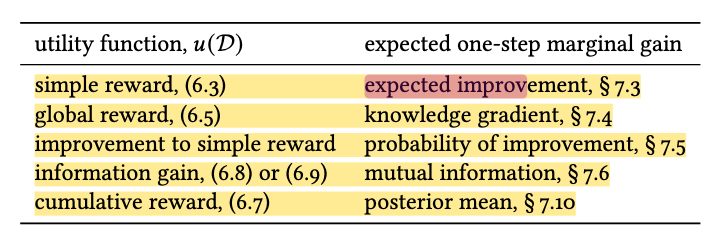

Navigating the search space in Bayesian optimization

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")
        
        plt.show()

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

In [5]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

model, likelihood = fit_gp_model(train_x, train_y)

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


  0%|          | 0/500 [00:00<?, ?it/s]

### Finding improvement in Bayesian optimization

Diagnosing the Probability of Improvement policy

iteration 0
incumbent tensor([1.4910]) tensor(2.1962)


  0%|          | 0/500 [00:00<?, ?it/s]

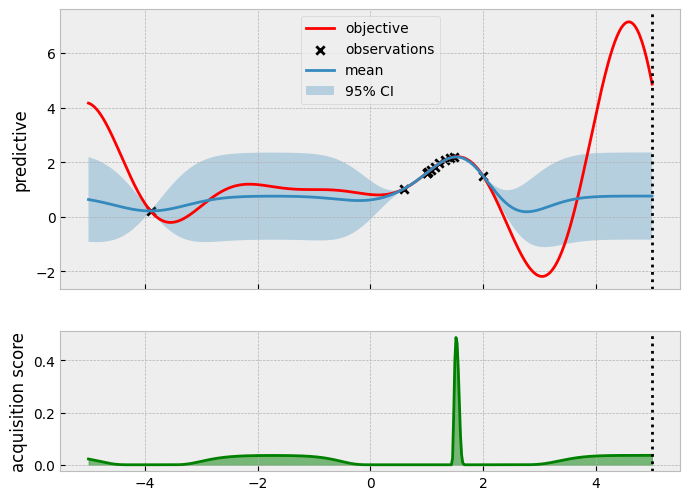

iteration 1
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

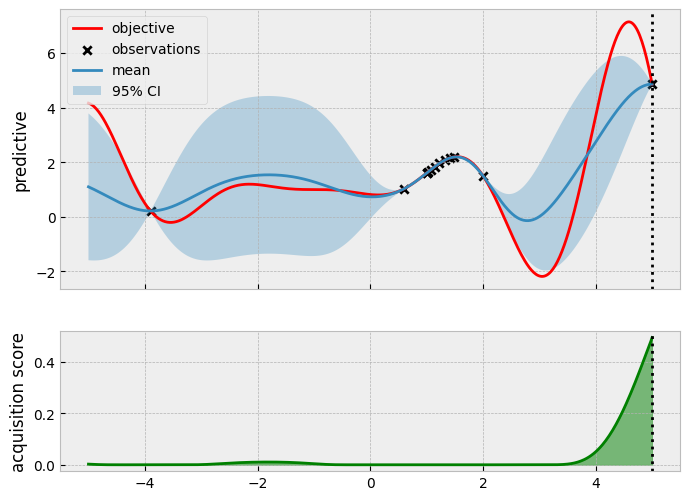

iteration 2
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

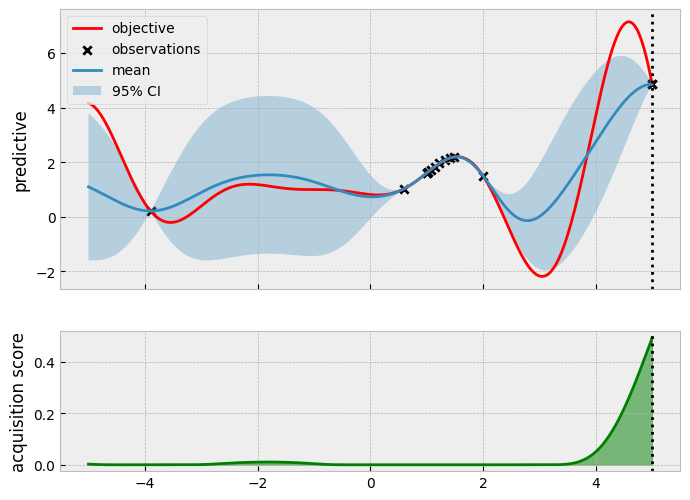

iteration 3
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

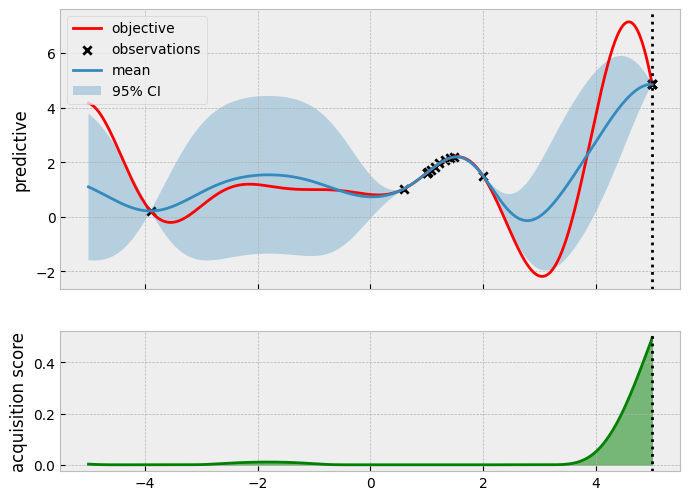

iteration 4
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

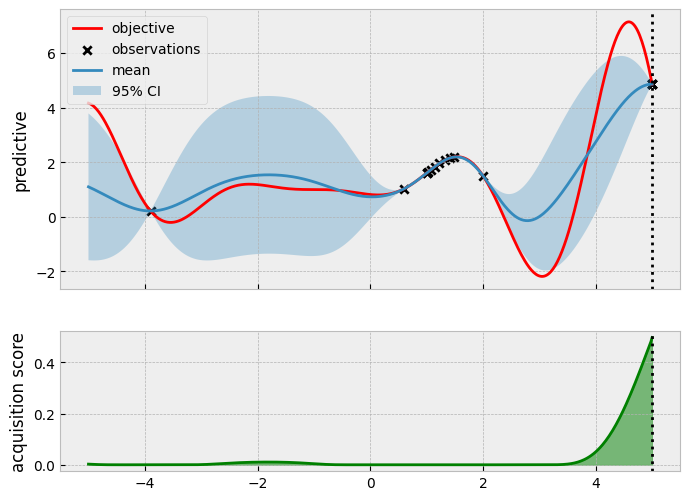

iteration 5
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

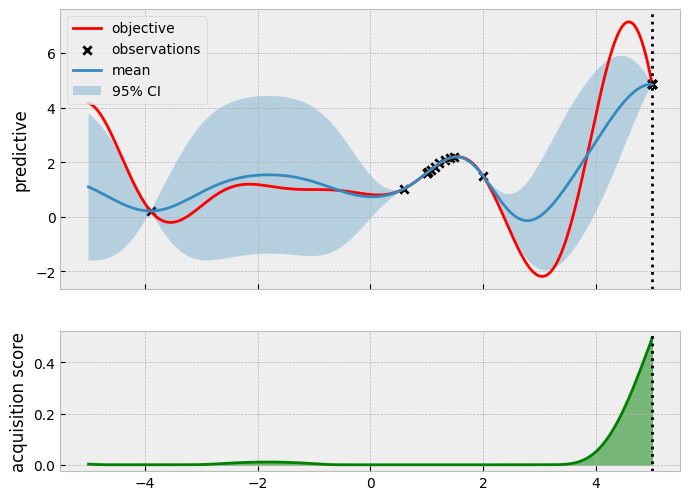

iteration 6
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

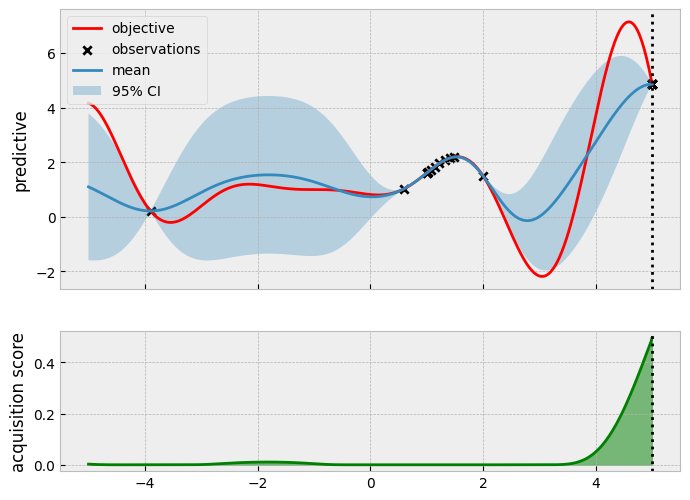

iteration 7
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

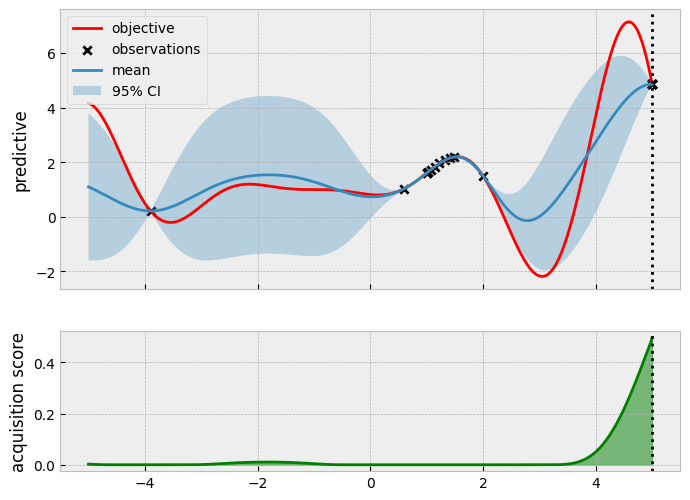

iteration 8
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

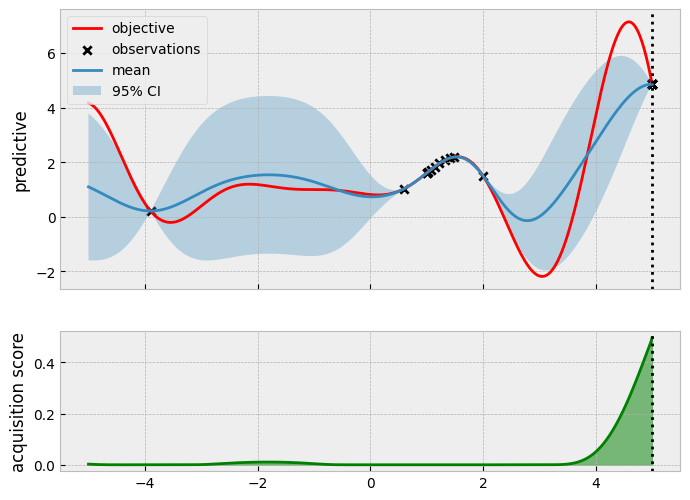

iteration 9
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

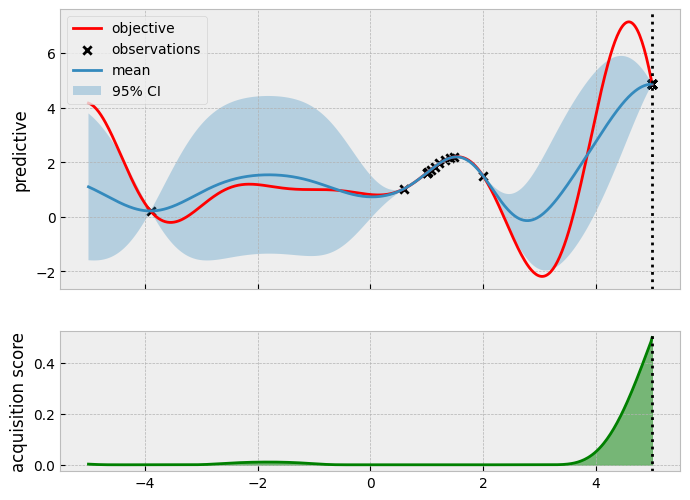

In [7]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    
    
    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

Optimizing the expected value of improvement

iteration 0
incumbent tensor([5.]) tensor(4.8633)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


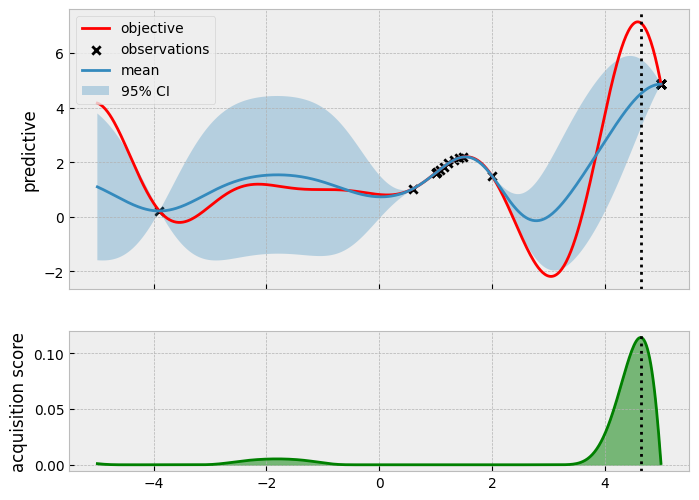

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083])
iteration 1
incumbent tensor([4.6386]) tensor(7.1083)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


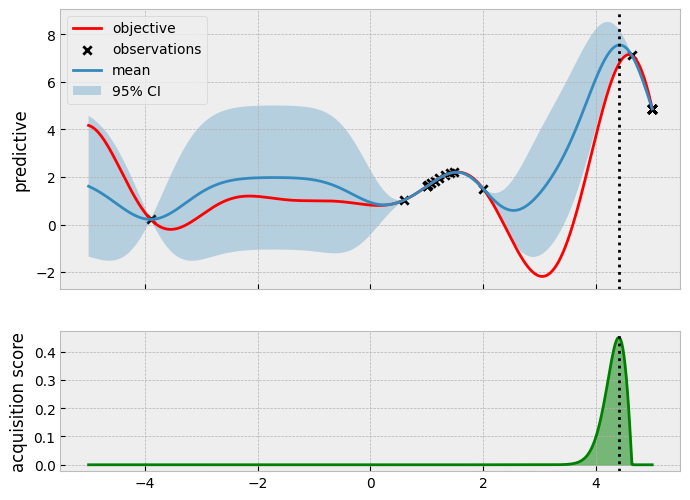

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083, 6.7483])
iteration 2
incumbent tensor([4.6386]) tensor(7.1083)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


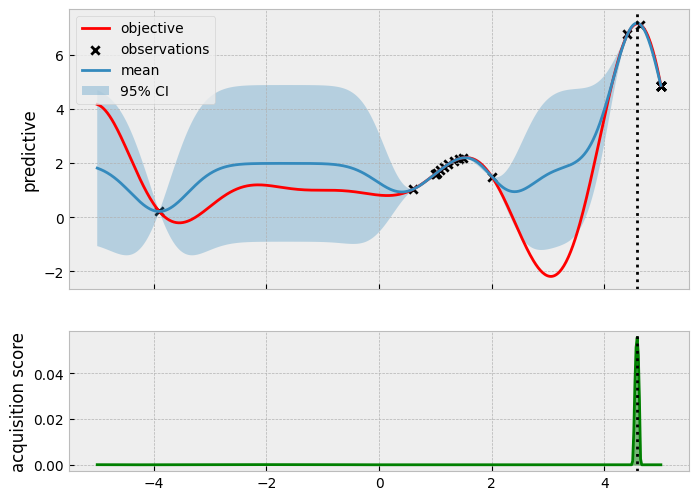

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083, 6.7483, 7.1428])
iteration 3
incumbent tensor([4.5775]) tensor(7.1428)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


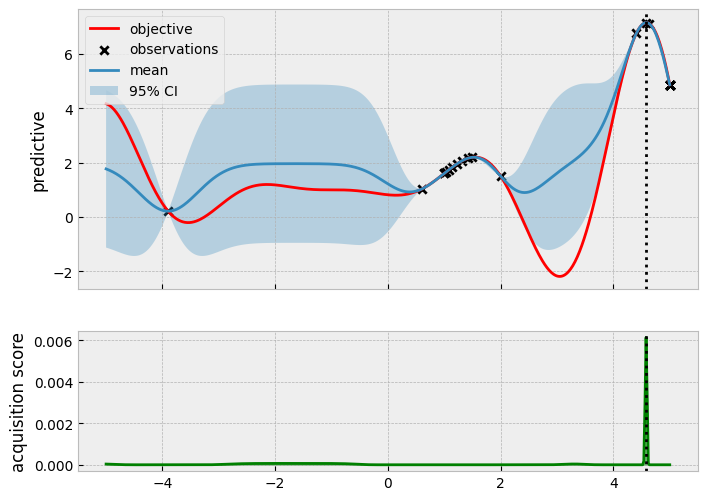

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083, 6.7483, 7.1428, 7.1435])
iteration 4
incumbent tensor([4.5818]) tensor(7.1435)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


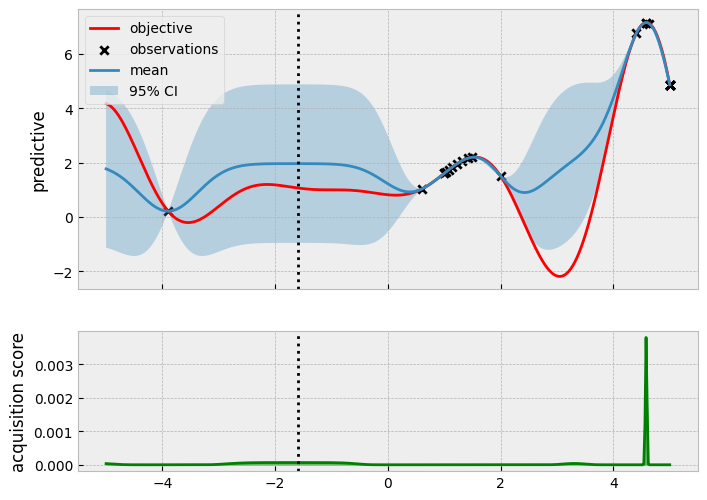

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083, 6.7483, 7.1428, 7.1435, 1.0649])
iteration 5
incumbent tensor([4.5818]) tensor(7.1435)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


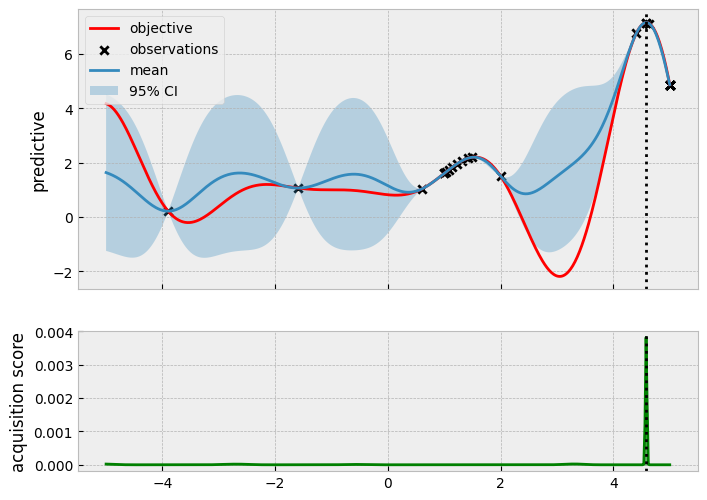

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921],
        [ 4.5826]])
tensor([1.6054, 1.5029, 1.0283, 1.6114, 1.6445, 1.7345, 1.8400, 1.9554, 2.0768,
        2.1612, 2.1962, 0.2160, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633, 4.8633,
        4.8633, 4.8633, 4.8633, 4.8633, 7.1083, 6.7483, 7.1428, 7.1435, 1.0649,
        7.1436])
iteration 6
incumbent tensor([4.5826]) tensor(7.1436)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


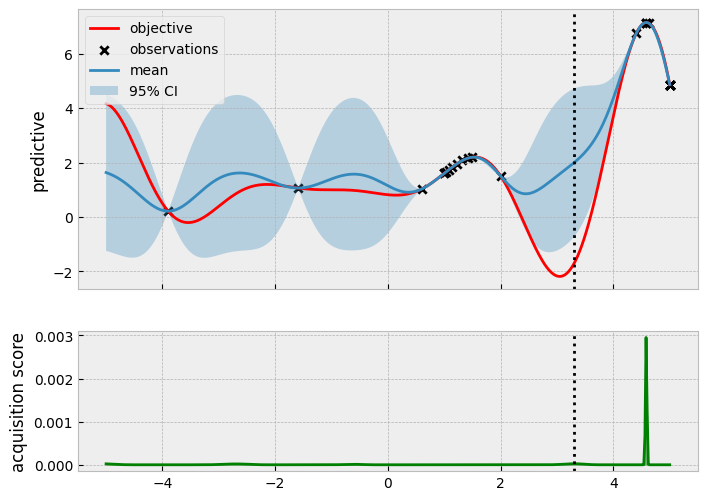

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921],
        [ 4.5826],
        [ 3.3048]])
tensor([ 1.6054,  1.5029,  1.0283,  1.6114,  1.6445,  1.7345,  1.8400,  1.9554,
         2.0768,  2.1612,  2.1962,  0.2160,  4.8633,  4.8633,  4.8633,  4.8633,
         4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  7.1083,  6.7483,
         7.1428,  7.1435,  1.0649,  7.1436, -1.6976])
iteration 7
incumbent tensor([4.5826]) tensor(7.1436)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


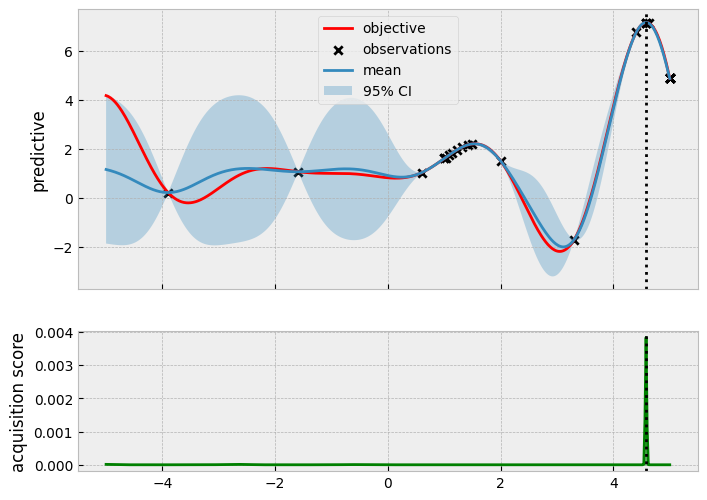

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921],
        [ 4.5826],
        [ 3.3048],
        [ 4.5800]])
tensor([ 1.6054,  1.5029,  1.0283,  1.6114,  1.6445,  1.7345,  1.8400,  1.9554,
         2.0768,  2.1612,  2.1962,  0.2160,  4.8633,  4.8633,  4.8633,  4.8633,
         4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  7.1083,  6.7483,
         7.1428,  7.1435,  1.0649,  7.1436, -1.6976,  7.1433])
iteration 8
incumbent tensor([4.5826]) tensor(7.1436)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


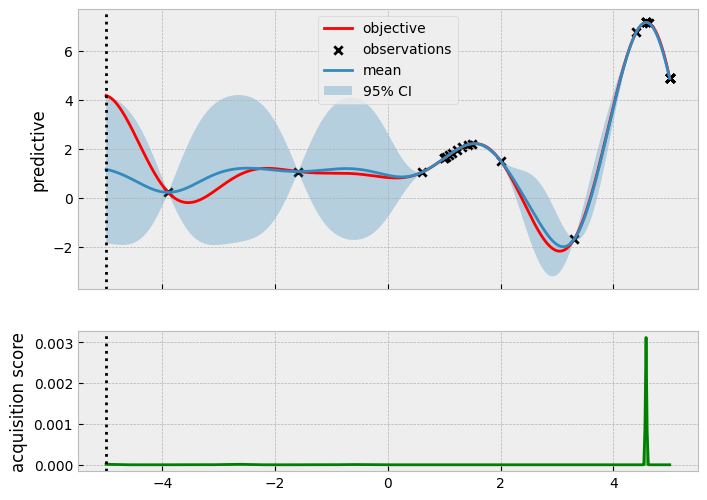

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921],
        [ 4.5826],
        [ 3.3048],
        [ 4.5800],
        [-5.0000]])
tensor([ 1.6054,  1.5029,  1.0283,  1.6114,  1.6445,  1.7345,  1.8400,  1.9554,
         2.0768,  2.1612,  2.1962,  0.2160,  4.8633,  4.8633,  4.8633,  4.8633,
         4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  7.1083,  6.7483,
         7.1428,  7.1435,  1.0649,  7.1436, -1.6976,  7.1433,  4.1659])
iteration 9
incumbent tensor([4.5826]) tensor(7.1436)


  0%|          | 0/500 [00:00<?, ?it/s]

/opt/anaconda3/envs/meng/lib/python3.10/site-packages/botorch/acquisition/analytic.py:331: NumericsWarning: ExpectedImprovement has known numerical issues that lead to suboptimal optimization performance. It is strongly recommended to simply replace

	 ExpectedImprovement 	 --> 	 LogExpectedImprovement 

instead, which fixes the issues and has the same API. See https://arxiv.org/abs/2310.20708 for details.
  legacy_ei_numerics_warning(legacy_name=type(self).__name__)


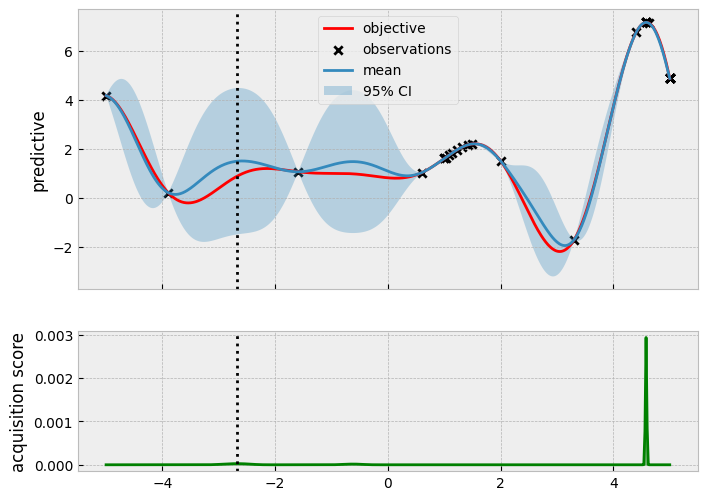

tensor([[ 1.0000],
        [ 2.0000],
        [ 0.5985],
        [ 1.0036],
        [ 1.0237],
        [ 1.0787],
        [ 1.1454],
        [ 1.2244],
        [ 1.3229],
        [ 1.4191],
        [ 1.4910],
        [-3.8990],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 5.0000],
        [ 4.6386],
        [ 4.4064],
        [ 4.5775],
        [ 4.5818],
        [-1.5921],
        [ 4.5826],
        [ 3.3048],
        [ 4.5800],
        [-5.0000],
        [-2.6758]])
tensor([ 1.6054,  1.5029,  1.0283,  1.6114,  1.6445,  1.7345,  1.8400,  1.9554,
         2.0768,  2.1612,  2.1962,  0.2160,  4.8633,  4.8633,  4.8633,  4.8633,
         4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  4.8633,  7.1083,  6.7483,
         7.1428,  7.1435,  1.0649,  7.1436, -1.6976,  7.1433,  4.1659,  0.8829])


In [8]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=train_y.max()
    )

    next_x, acq_val = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50,
    )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

    print(train_x)
    print(train_y)